# Spacecraft Pose Estimation Model Example

In [1]:
%matplotlib inline
USE_GPU = False

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from random import randint
from dataloader_utils import *
torch.manual_seed(42)

if USE_GPU:
    print(torch.cuda.is_available())

True


## Testing dataloader

In [3]:
dataset_root_dir = '../../speed'
annotations_root_dir = '../annotations'

sample_transform = transforms.Compose([
    transforms.RandomRotation((-30, 30))
])

sample_dataset = SpeedDataset(speed_root=dataset_root_dir, annotations_root=annotations_root_dir, transform=sample_transform)

Bounding box [x_min, y_min, x_max, y_max]: [1130.80900426  430.31181948  790.14211659  364.85722843]


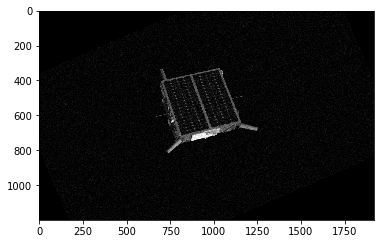

In [4]:
img, label = sample_dataset[100]
plt.figure()
plt.imshow(img)
print("Bounding box [x_min, y_min, x_max, y_max]: {}".format(label[-4:]))

## Dataloading

In [5]:
# Transforms
train_transform = transforms.Compose([
    # transforms.RandomRotation((-15, 15)),
    # transforms.CenterCrop(1200), # TEST: center crop then resize should help not lose the satellite during resizing
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # transforms.Normalize([0.5],[0.5])
])

sanity_transform = transforms.Compose([
    # transforms.CenterCrop(1200),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # transforms.Normalize([0.5],[0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # transforms.Normalize([0.5],[0.5])
])

In [6]:
# Datasets
# NOTE: we don't have the labels for the test set, so we need to split the training set
training_dataset = SpeedDataset(
    split="train",
    split_index=1000, # used to make a smaller training set for dev
    speed_root=dataset_root_dir,
    annotations_root=annotations_root_dir,        
    transform=train_transform
)

sanity_dataset = SpeedDataset(
    split="train",
    sanity_check=100,
    speed_root=dataset_root_dir,
    annotations_root=annotations_root_dir,        
    transform=sanity_transform
)

# val_dataset = SpeedDataset(
#     split="test",
#     speed_root=dataset_root_dir,
#     annotations_root=annotations_root_dir,        
#     transform=val_transform
# )

In [7]:
(train_len, test_len) = (int(0.85*len(training_dataset)), int(0.15*len(training_dataset)))
assert train_len + test_len == len(training_dataset)
train_dataset, test_dataset = torch.utils.data.random_split(training_dataset, (train_len, test_len))

In [8]:
# Dataloading
WORKERS=6
train_loader = DataLoader(train_dataset, batch_size=16, num_workers=WORKERS, shuffle=False) # NOTE: set shuffle to True!
sanity_loader = DataLoader(sanity_dataset, batch_size=1, num_workers=WORKERS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=WORKERS, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=1, num_workers=WORKERS, shuffle=False)

## Existing network implementations (1/2)

The following is a pytorch implementation of [Deep3dBox](https://arxiv.org/pdf/1612.00496.pdf). Geometric constraints are used to solve for the translation (even though it is known to lock errors in if the 2D bounding box is inaccurate; see [MonoPSR](https://arxiv.org/pdf/1904.01690.pdf) or [Cascade geometric constratins](https://arxiv.org/pdf/1909.01867.pdf) for better alternatives). However, all these approaches focus on 3D bounding box estimation for cars and as a result, they can make pretty big assumptions about the orientation of the vehicle (i.e., roll and pitch equal to zero). These papers use multi-task CNN and multi-bin losses and would need to be extended to recover the full 6DOF.

In [9]:
# Pre-trained layers
DEEP3D = False
if DEEP3D:
    vgg = models.vgg19_bn(pretrained=True)

In [10]:
# Input size: 224x224 (imposed by vgg pretrained layers)

def OrientationLoss(orient_batch, orientGT_batch, confGT_batch):

    batch_size = orient_batch.size()[0]
    indexes = torch.max(confGT_batch, dim=1)[1]

    # extract just the important bin
    orientGT_batch = orientGT_batch[torch.arange(batch_size), indexes]
    orient_batch = orient_batch[torch.arange(batch_size), indexes]

    theta_diff = torch.atan2(orientGT_batch[:,1], orientGT_batch[:,0])
    estimated_theta_diff = torch.atan2(orient_batch[:,1], orient_batch[:,0])

    return -1 * torch.cos(theta_diff - estimated_theta_diff).mean()


class Deep3dBoxNet(nn.Module):
    def __init__(self, features=None, bins=2, w = 0.4):
        super(Deep3dBoxNet, self).__init__()
        self.bins = bins
        self.w = w
        self.features = features
        self.orientation = nn.Sequential(
                    nn.Linear(512 * 7 * 7, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, bins*2) # to get sin and cos
                )
        self.confidence = nn.Sequential(
                    nn.Linear(512 * 7 * 7, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, bins),
                    # nn.Softmax()
                    #nn.Sigmoid()
                )
        self.dimension = nn.Sequential(
                    nn.Linear(512 * 7 * 7, 512),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(512, 512),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(512, 3)
                )

    def forward(self, x):
        x = self.features(x) # 512 x 7 x 7
        x = x.view(-1, 512 * 7 * 7)
        orientation = self.orientation(x)
        orientation = orientation.view(-1, self.bins, 2)
        orientation = F.normalize(orientation, dim=2)
        confidence = self.confidence(x)
        dimension = self.dimension(x)
        return orientation, confidence, dimension

In [11]:
# Testing model with pretrained weights (epoch10) on Kitti
if DEEP3D:
    weight_filepath = '../weights/epoch_10.pkl'
    if USE_GPU == True:
        model = Deep3dBoxNet(features=vgg.features, bins=2).cuda()
    else:
        model = Deep3dBoxNet(features=vgg.features, bins=2)
    checkpoint = torch.load(weight_filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    # model.eval()

## Existing network implementations (2/2)
The following is an end-to-end implementation based on [USRO](https://arxiv.org/pdf/1907.04298.pdf) which seeks simplicity over efficiency. The team finished in 3rd place using resnet101 as their backbone. This implementation relies on resnet34 instead for computational reasons. Being more straightforward, this implementation is more suited to a study of domain adaptation.

In [12]:
# Pre-trained layers
resnet = models.resnet34(pretrained=True)

In [13]:
class URSONet(nn.Module):
    def __init__(self, criterion=None):
        super(URSONet, self).__init__()

        # Resnet backbone
        self.resnet = nn.Sequential(*list(resnet.children())[:-2]) 
        self.conv6 = nn.Conv2d(512, 1024, 3, 2)
        self.bn1 = nn.BatchNorm2d(1024)
        
        # Translation branch: t = [tx, ty, tz]
        # self.fc_t = nn.Linear(4*4*1024, 3)
        self.fc_t1 = nn.Linear(3*3*1024, 1024)
        self.fc_t2 = nn.Linear(1024, 3)

        # Attitude branch: q = [q0, q1, q2, q3]
        # NOTE: this assumes quaternions as attitude descriptors
        # self.fc_att = nn.Linear(4*4*1024, 4)
        self.fc_att1 = nn.Linear(3*3*1024, 1024)
        self.fc_att2 = nn.Linear(1024, 4)        
    
    def forward(self, input, gt=None):
        # Input size: 256x256
        # x = F.relu(self.resnet(input)) # NOTE: should we add activation after resnet?
        x = self.resnet(input)
        x = F.relu(self.bn1(self.conv6(x)))
        # Reshape after bottleneck
        x_t = x.view(-1, 3*3*1024)
        x_att = x.view(-1, 3*3*1024)

        # T regression
        x_t = F.relu(self.fc_t1(x_t))
        x_t = self.fc_t2(x_t)

        # q regression
        x_att = F.relu(self.fc_att1(x_att))
        x_att = self.fc_att2(x_att)

        return x_t, x_att

### Training

In [14]:
OVERFIT=False
if OVERFIT:
    overfit_net = URSONet()
    if USE_GPU:
        overfit_net = overfit_net.cuda()

In [15]:
def get_of_optimizer(net):
    # optimizer = torch.optim.Adam(net.parameters())
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=0.0001,
                                weight_decay=0.0001,
                                momentum=0.9)
    return optimizer

In [16]:
def translation_loss(t, t_pred):
    return torch.mean(torch.norm((t - t_pred)/torch.norm(t_pred)))
    # return torch.cdist(t, t_pred, p=2)


In [17]:
def attitude_loss(att, att_pred):
    #TODO: should not take L2 norm of quaternion difference --> find better more accurate loss metric
    # return torch.mean(torch.norm((att - att_pred)/torch.norm(att_pred)))
    return torch.mean(torch.cdist(att, att_pred/torch.norm(att_pred), p=2))

In [18]:
def train(train_loader, net, optimizer, loss_graph):
    for i, data in enumerate(train_loader):
        inputs, target = data
        if USE_GPU:
            inputs = inputs.cuda()
            target = target.cuda()
        att_gt = target[0][:4].float()
        t_gt = target[0][4:7].float()

        optimizer.zero_grad()
        t, att = net(inputs)

        L_t = translation_loss(t[None], t_gt[None])
        L_att = attitude_loss(att[None], att_gt[None])
        total_loss = L_t.view(1)[0] + L_att.view(1)[0] + 1.2*(torch.abs(1 - torch.norm(att)))
        loss_graph.append(total_loss.item())

        # loss_graph.append(total_loss.item())
        total_loss.backward()
        optimizer.step()
    return total_loss

In [19]:
EPOQUE = 120

if OVERFIT:
    # Training mode
    overfit_net.train()

    optimizer = get_of_optimizer(overfit_net)

    print("Starting Training...")

    loss_graph = []

    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
    ax = fig.add_subplot(1,1,1)


    for e in range(EPOQUE):
        loss = train(sanity_loader, overfit_net, optimizer, loss_graph)
        ax.clear()
        ax.set_xlabel('iterations')
        ax.set_ylabel('loss value')
        ax.set_title('Training loss curve for OVERFIT_NET')
        ax.plot(loss_graph, label='training loss')
        ax.legend(loc='upper right')
        fig.canvas.draw()
        print("Epoch: {} Loss: {}".format(e, loss))

### Evaluation

In [20]:
if OVERFIT:
    overfit_net.eval()
    img1, _ = sanity_dataset[0]
    label1 = sanity_dataset.labels[0]
    if USE_GPU:
        oimg1 = img1.cuda()
    t_out, att_out = overfit_net.forward(oimg1[None])
    t_out = t_out.detach().cpu().numpy()[0]
    att_out = att_out.detach().cpu().numpy()[0]
    img1 = img1.permute(1, 2, 0).numpy()
    sanity_dataset.visualize_output(img1, label1, t_out, att_out, bbox=True)

## Training
Training on entire dataset

In [21]:
def get_optimizer(net):
    # optimizer = torch.optim.Adam(net.parameters())
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=0.0001,
                                weight_decay=0.0001,
                                momentum=0.9)
    return optimizer

Starting Training...
Epoch: 0 Loss: 2.0792012214660645
Epoch: 1 Loss: 1.8576712608337402
Epoch: 2 Loss: 1.7813420295715332
Epoch: 3 Loss: 1.7664289474487305
Epoch: 4 Loss: 2.152503252029419
Epoch: 5 Loss: 1.7505948543548584
Epoch: 6 Loss: 2.013401985168457
Epoch: 7 Loss: 1.965728759765625
Epoch: 8 Loss: 2.261931896209717
Epoch: 9 Loss: 2.094834089279175
CPU times: user 3min 49s, sys: 8.98 s, total: 3min 58s
Wall time: 4min 45s


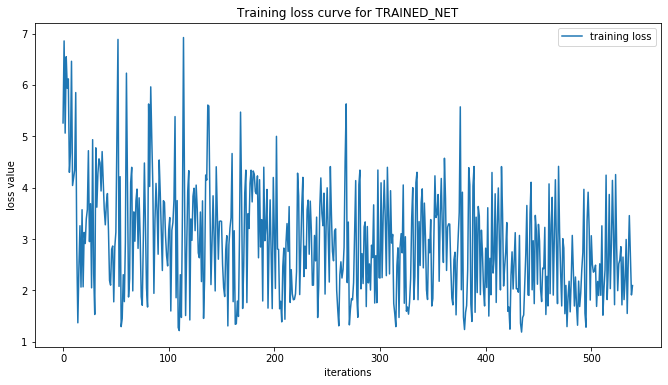

In [22]:
%%time
EPOCH = 12
trained_net = URSONet()
if USE_GPU:
    trained_net = trained_net.cuda()
optimizer = get_optimizer(trained_net)
# switch to train mode
trained_net.train()

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)


for e in range(EPOCH):
    loss = train(train_loader, trained_net, optimizer, loss_graph)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for TRAINED_NET')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))

## Testing

In [23]:
def evaluate(val_loader, net):
    total_loss = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, target = data

            if USE_GPU:
                inputs = inputs.cuda()
                target = target.cuda()

            att_gt = target[0][:4].float()
            t_gt = target[0][4:7].float()

            t, att = net(inputs)

            L_t = translation_loss(t[None], t_gt[None])
            L_att = attitude_loss(att[None], att_gt[None])
            # print(1-torch.norm(att))
            total_loss += L_t.view(1)[0] + L_att.view(1)[0] + 1.2*(torch.abs(1 - torch.norm(att)))

    return total_loss / len(val_loader)

In [24]:
# switch to evaluation mode
# TODO: need more informative metric
trained_net.eval()
test_loss = evaluate(test_loader, trained_net)
print("Test error: {}".format(test_loss))

Test error: 2.592193365097046


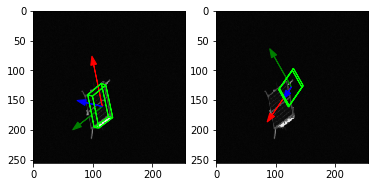

In [25]:
# Compare the learned pose to the ground-truth
%matplotlib inline
idx = 89
img1, label1 = test_dataset[idx]
# label1 = test_dataset.dataset.labels[idx]
if USE_GPU:
    img1 = img1.cuda()
t_out, att_out = trained_net.forward(img1[None])
t_out = t_out.detach().cpu().numpy()[0]
att_out = att_out.detach().cpu().numpy()[0]
img1 = img1.permute(1, 2, 0).cpu().numpy()
test_dataset.dataset.visualize_output(img1, label1, t_out, att_out, bbox=True)

In [ ]:
# NOTE: simply rescaling may affect the training performance as the satellite is sometimes cut in half